In [3]:
library(GenomicRanges)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(org.Hs.eg.db)
library(annotate)
library(stringr)
library(XML)
library(qqman)
library(rtracklayer)

In [4]:
data <- read.csv(file='../data/candidates_574.csv')
data$chr <- sub("^", "chr", data$chr)

data$X <- NULL

data$i <- NULL
data

chr,start,end,WestEurasia.SouthAsia,WestEurasia.Africa,WestEurasia.CentralAsiaSiberia,WestEurasia.Oceania,WestEurasia.America,WestEurasia.EastAsia,SouthAsia.Africa,⋯,Africa.CentralAsiaSiberia,Africa.Oceania,Africa.America,Africa.EastAsia,CentralAsiaSiberia.Oceania,CentralAsiaSiberia.America,CentralAsiaSiberia.EastAsia,Oceania.America,Oceania.EastAsia,America.EastAsia
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,8359739,8364181,NA,NA,0.24315,NA,0.39153,NA,NA,⋯,0.21795,NA,0.36120,NA,NA,NA,0.22035,0.31300,NA,0.36420
chr1,9845436,9863387,NA,NA,NA,NA,0.26365,NA,NA,⋯,NA,NA,0.32252,NA,NA,NA,NA,0.21695,NA,NA
chr1,13725296,13733660,NA,NA,NA,NA,NA,NA,NA,⋯,NA,0.23619,0.23093,NA,0.35185,0.34632,NA,NA,NA,NA
chr1,14436060,14439381,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.22469
chr1,16148564,16154830,NA,NA,NA,NA,NA,NA,NA,⋯,NA,0.23843,NA,NA,0.40450,NA,NA,NA,0.31536,NA
chr1,24519544,24525820,NA,NA,NA,NA,NA,NA,NA,⋯,NA,0.65635,NA,0.27879,0.38811,NA,NA,0.63648,NA,0.23563
chr1,33191170,33199640,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,0.20886,NA,NA,NA,NA,NA,NA,NA
chr1,62112538,62120128,NA,NA,NA,NA,0.23412,NA,NA,⋯,NA,NA,0.39356,NA,NA,NA,NA,NA,NA,NA
chr1,62620869,62625863,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,0.35096,NA,NA,NA,NA,0.35439,NA,0.35764


In [5]:
coordinates <- data[, c(1,2,3)]
names(coordinates) <- c("Chromosome", "Start", "End")

In [6]:
intervals = GenomicRanges::makeGRangesFromDataFrame(coordinates)
txdb = TxDb.Hsapiens.UCSC.hg19.knownGene

In [7]:
intervals

GRanges object with 574 ranges and 0 metadata columns:
        seqnames              ranges strand
           <Rle>           <IRanges>  <Rle>
    [1]     chr1     8359739-8364181      *
    [2]     chr1     9845436-9863387      *
    [3]     chr1   13725296-13733660      *
    [4]     chr1   14436060-14439381      *
    [5]     chr1   16148564-16154830      *
    ...      ...                 ...    ...
  [570]     chrX 146037797-146042345      *
  [571]     chrX 146360192-146369374      *
  [572]     chrX 154788811-154840186      *
  [573]     chrX 154789310-154826421      *
  [574]     chrX 154908191-154948137      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [8]:
#Gene ids 
genes = genes(txdb)

  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [9]:
# Annotating function
annotateIntervals <-
    function(intervals, txdb)
{
    stopifnot(is(intervals, "GRanges"), is(txdb, "TxDb"))
    anno = genes(txdb)
    olaps = findOverlaps(intervals, anno)
    mcols(olaps)$gene_id = genes$gene_id[subjectHits(olaps)]
    intervals_factor = factor(queryHits(olaps), levels=seq_len(queryLength(olaps)))
    intervals$gene_id = splitAsList(mcols(olaps)$gene_id, intervals_factor)
    intervals
}     

In [10]:
myAnnotation <- as.data.frame(annotateIntervals(intervals, txdb))
myDf_master <- data.frame()


  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [11]:
for (i in 1:length(myAnnotation$gene_id)) {
  if(length(c(na.omit(myAnnotation$gene_id[i])[[1]])) != 0) {
  myDf <- data.frame(myAnnotation$seqnames[i], myAnnotation$start[i], 
    myAnnotation$end[i], toString(unname(getSYMBOL(c(na.omit(myAnnotation$gene_id[i])[[1]]), data='org.Hs.eg'))))
  myDf_master <- rbind(myDf_master, myDf)
 }
}


In [12]:
myDf_header <- c("chr", "start", "end", "genes")
names(myDf_master) <- myDf_header


In [13]:
df_merge <- merge(myDf_master,data,by=c("chr", "start","end"))
df_merge

chr,start,end,genes,WestEurasia.SouthAsia,WestEurasia.Africa,WestEurasia.CentralAsiaSiberia,WestEurasia.Oceania,WestEurasia.America,WestEurasia.EastAsia,⋯,Africa.CentralAsiaSiberia,Africa.Oceania,Africa.America,Africa.EastAsia,CentralAsiaSiberia.Oceania,CentralAsiaSiberia.America,CentralAsiaSiberia.EastAsia,Oceania.America,Oceania.EastAsia,America.EastAsia
<fct>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,108729310,108737787,SLC25A24,NA,NA,NA,NA,NA,NA,⋯,NA,0.28019,0.50669,0.25098,NA,0.25789,NA,NA,NA,NA
chr1,109573089,109580939,WDR47,NA,NA,NA,NA,NA,NA,⋯,NA,NA,0.21935,NA,NA,NA,NA,NA,NA,NA
chr1,110215300,110257943,"GSTM1, GSTM2, GSTM5",NA,NA,NA,NA,NA,NA,⋯,NA,0.22606,NA,NA,NA,NA,NA,NA,NA,NA
chr1,13725296,13733660,PRAMEF20,NA,NA,NA,NA,NA,NA,⋯,NA,0.23619,0.23093,NA,0.35185,0.34632,NA,NA,NA,NA
chr1,144452805,144456917,"NBPF20, NA",NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
chr1,144488959,144522495,"NBPF20, NA",NA,NA,NA,NA,NA,NA,⋯,NA,0.26155,0.24433,NA,NA,NA,NA,NA,NA,NA
chr1,144612537,144622084,"NBPF20, PFN1P2",NA,NA,NA,NA,NA,NA,⋯,0.20018,NA,NA,NA,NA,NA,NA,NA,NA,NA
chr1,144906613,144908385,"NBPF20, LOC653513, PDE4DIP",NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.21593,NA
chr1,144908385,144910495,"NBPF20, LOC653513, PDE4DIP",NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.21593,NA


In [14]:
df_merge$chr <- gsub("chr","",as.character(df_merge$chr))

write.csv(df_merge,"vst_574_candidates_gene_anotation.csv", row.names = FALSE)


### Changing X chromosome to 23 for manhattan plot 
df_merge$chr <- as.integer(df_merge$chr)
df_merge$chr[is.na(df_merge$chr)] <- 23
df_merge

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


chr,start,end,genes,WestEurasia.SouthAsia,WestEurasia.Africa,WestEurasia.CentralAsiaSiberia,WestEurasia.Oceania,WestEurasia.America,WestEurasia.EastAsia,⋯,Africa.CentralAsiaSiberia,Africa.Oceania,Africa.America,Africa.EastAsia,CentralAsiaSiberia.Oceania,CentralAsiaSiberia.America,CentralAsiaSiberia.EastAsia,Oceania.America,Oceania.EastAsia,America.EastAsia
<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,108729310,108737787,SLC25A24,NA,NA,NA,NA,NA,NA,⋯,NA,0.28019,0.50669,0.25098,NA,0.25789,NA,NA,NA,NA
1,109573089,109580939,WDR47,NA,NA,NA,NA,NA,NA,⋯,NA,NA,0.21935,NA,NA,NA,NA,NA,NA,NA
1,110215300,110257943,"GSTM1, GSTM2, GSTM5",NA,NA,NA,NA,NA,NA,⋯,NA,0.22606,NA,NA,NA,NA,NA,NA,NA,NA
1,13725296,13733660,PRAMEF20,NA,NA,NA,NA,NA,NA,⋯,NA,0.23619,0.23093,NA,0.35185,0.34632,NA,NA,NA,NA
1,144452805,144456917,"NBPF20, NA",NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,144488959,144522495,"NBPF20, NA",NA,NA,NA,NA,NA,NA,⋯,NA,0.26155,0.24433,NA,NA,NA,NA,NA,NA,NA
1,144612537,144622084,"NBPF20, PFN1P2",NA,NA,NA,NA,NA,NA,⋯,0.20018,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,144906613,144908385,"NBPF20, LOC653513, PDE4DIP",NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.21593,NA
1,144908385,144910495,"NBPF20, LOC653513, PDE4DIP",NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.21593,NA


In [15]:
#Input for Manhattan plot
SNP <- df_merge$genes
CHR <- df_merge$chr
BP <- df_merge$start
P <- df_merge$Africa.America
df <- data.frame(SNP,CHR,BP,P)
df$P[is.na(df$P)] <- 0

df

SNP,CHR,BP,P
<chr>,<dbl>,<int>,<dbl>
SLC25A24,1,108729310,0.50669
WDR47,1,109573089,0.21935
"GSTM1, GSTM2, GSTM5",1,110215300,0.00000
PRAMEF20,1,13725296,0.23093
"NBPF20, NA",1,144452805,0.00000
"NBPF20, NA",1,144488959,0.24433
"NBPF20, PFN1P2",1,144612537,0.00000
"NBPF20, LOC653513, PDE4DIP",1,144906613,0.00000
"NBPF20, LOC653513, PDE4DIP",1,144908385,0.00000


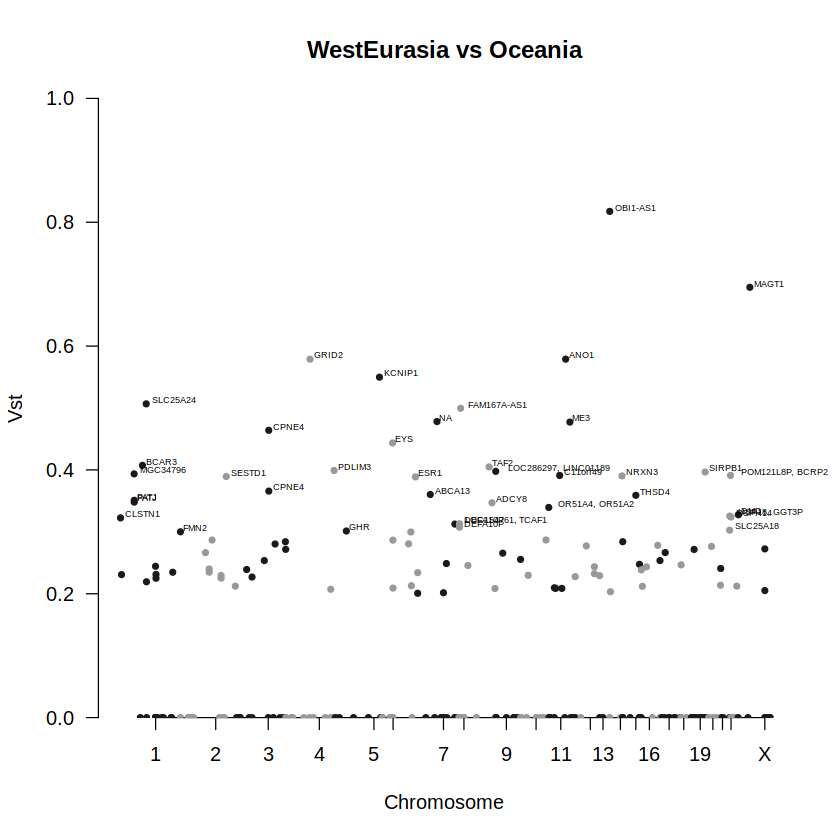

In [16]:
manhattan(df, logp = FALSE, annotatePval= 0.30,  annotateTop = FALSE, ylab="Vst", main='WestEurasia vs Oceania', chrlabs= c(1:22,"X"))

<h1> Manhattan plot for each group

In [17]:
SNP <- df_merge$genes
CHR <- as.integer(df_merge$chr)
BP <- df_merge$start
#P <- df_merge$WestEurasia.Oceania

coordinates <- data.frame(SNP,CHR,BP)
coordinates$CHR[is.na(coordinates$CHR)] <- "X"
coordinates


SNP,CHR,BP
<chr>,<chr>,<int>
SLC25A24,1,108729310
WDR47,1,109573089
"GSTM1, GSTM2, GSTM5",1,110215300
PRAMEF20,1,13725296
"NBPF20, NA",1,144452805
"NBPF20, NA",1,144488959
"NBPF20, PFN1P2",1,144612537
"NBPF20, LOC653513, PDE4DIP",1,144906613
"NBPF20, LOC653513, PDE4DIP",1,144908385


In [18]:
names(df_merge[5:25])

[1] "WestEurasia.SouthAsia"          "WestEurasia.Africa"            
 [3] "WestEurasia.CentralAsiaSiberia" "WestEurasia.Oceania"           
 [5] "WestEurasia.America"            "WestEurasia.EastAsia"          
 [7] "SouthAsia.Africa"               "SouthAsia.CentralAsiaSiberia"  
 [9] "SouthAsia.Oceania"              "SouthAsia.America"             
[11] "SouthAsia.EastAsia"             "Africa.CentralAsiaSiberia"     
[13] "Africa.Oceania"                 "Africa.America"                
[15] "Africa.EastAsia"                "CentralAsiaSiberia.Oceania"    
[17] "CentralAsiaSiberia.America"     "CentralAsiaSiberia.EastAsia"   
[19] "Oceania.America"                "Oceania.EastAsia"              
[21] "America.EastAsia"

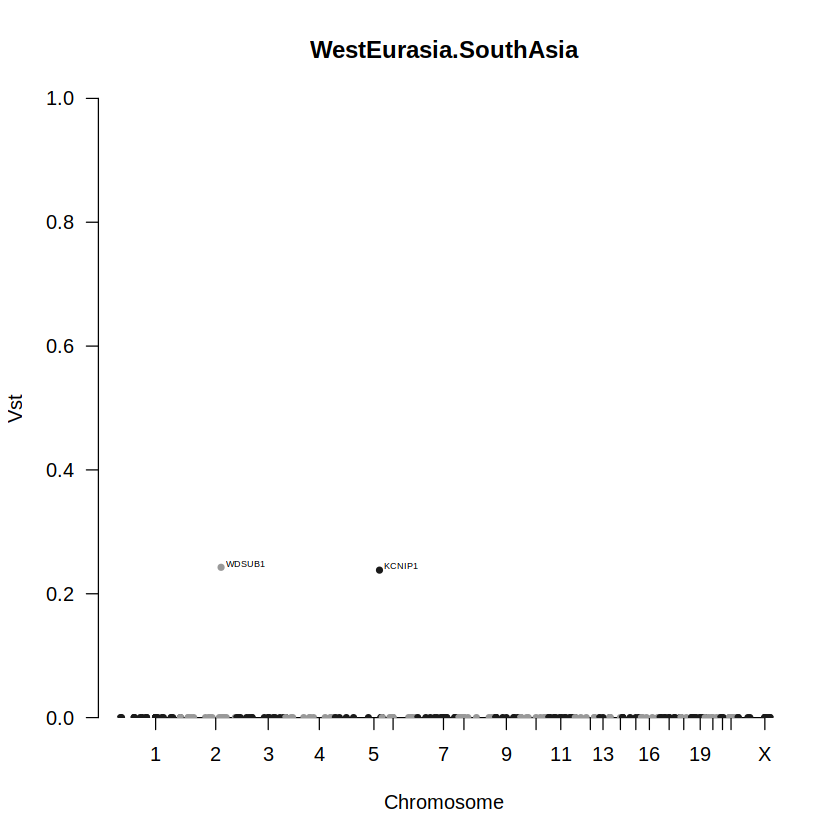

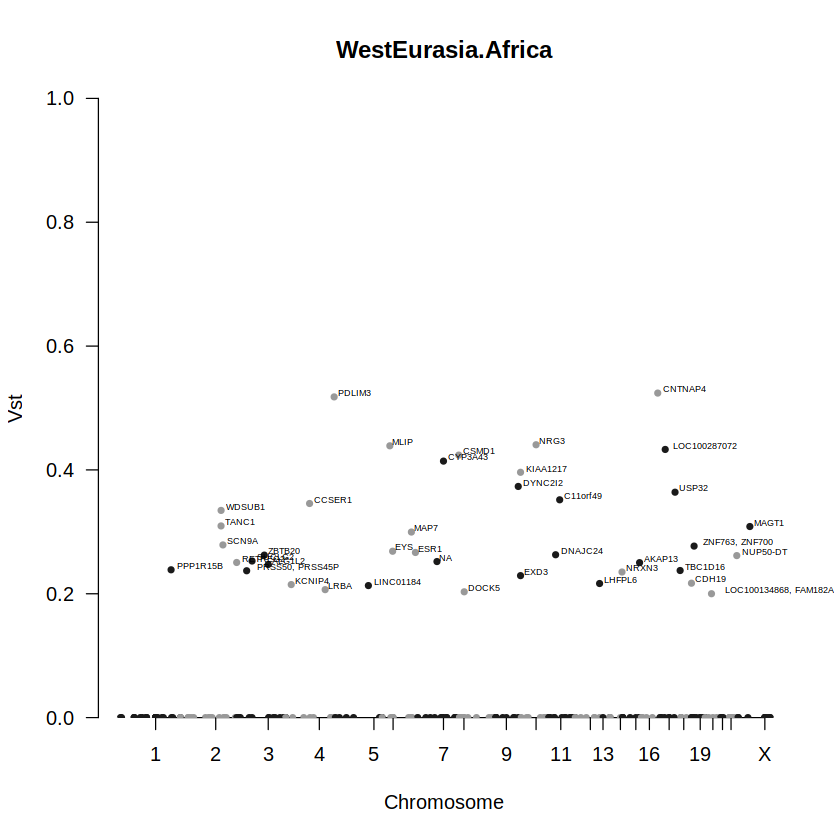

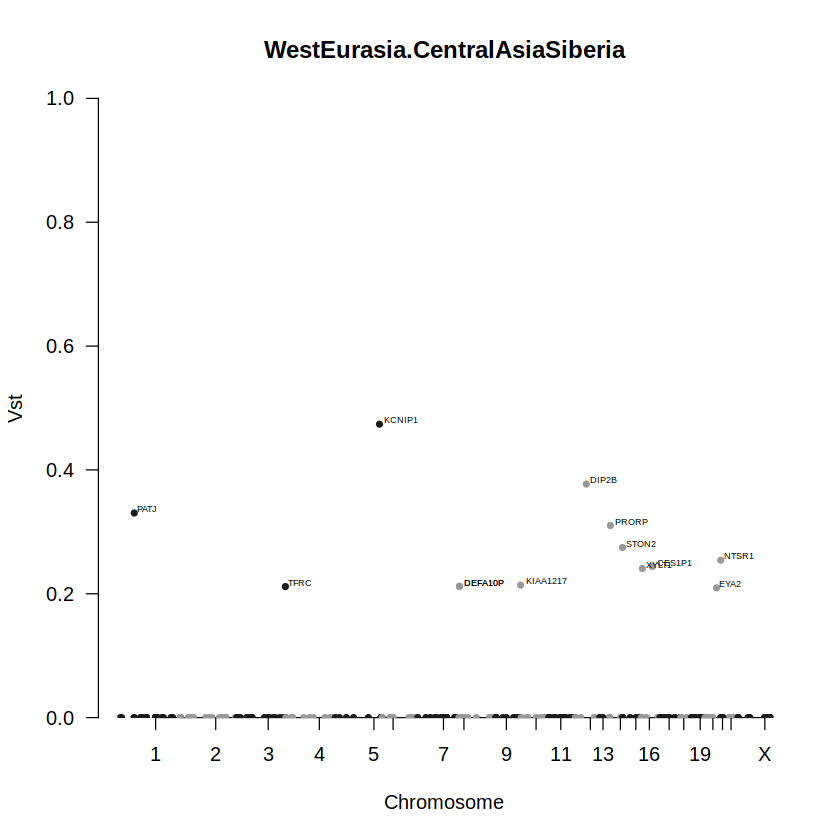

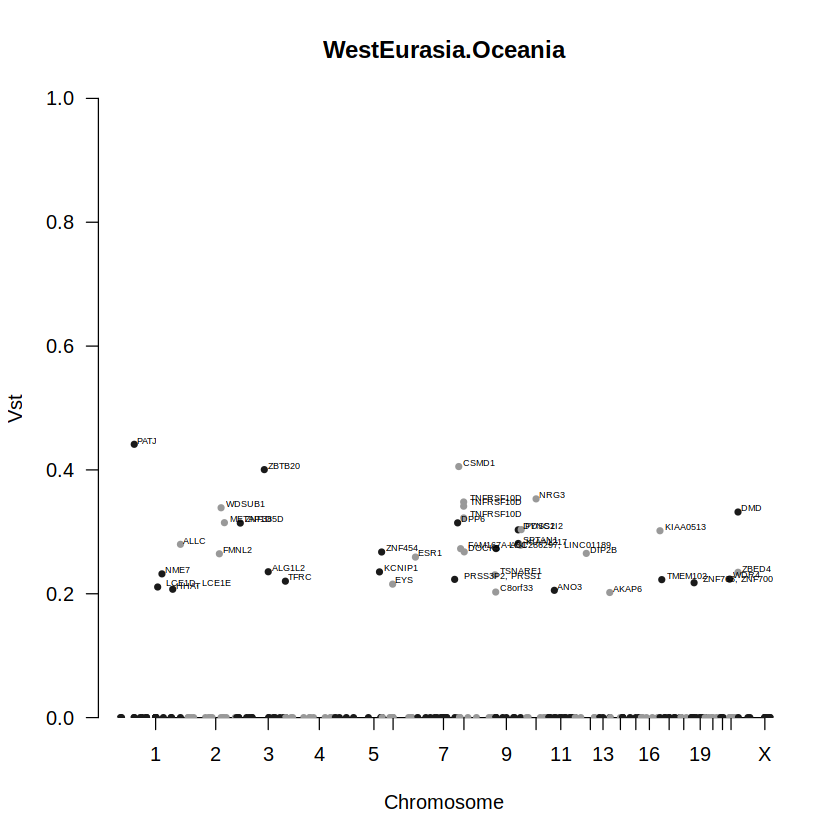

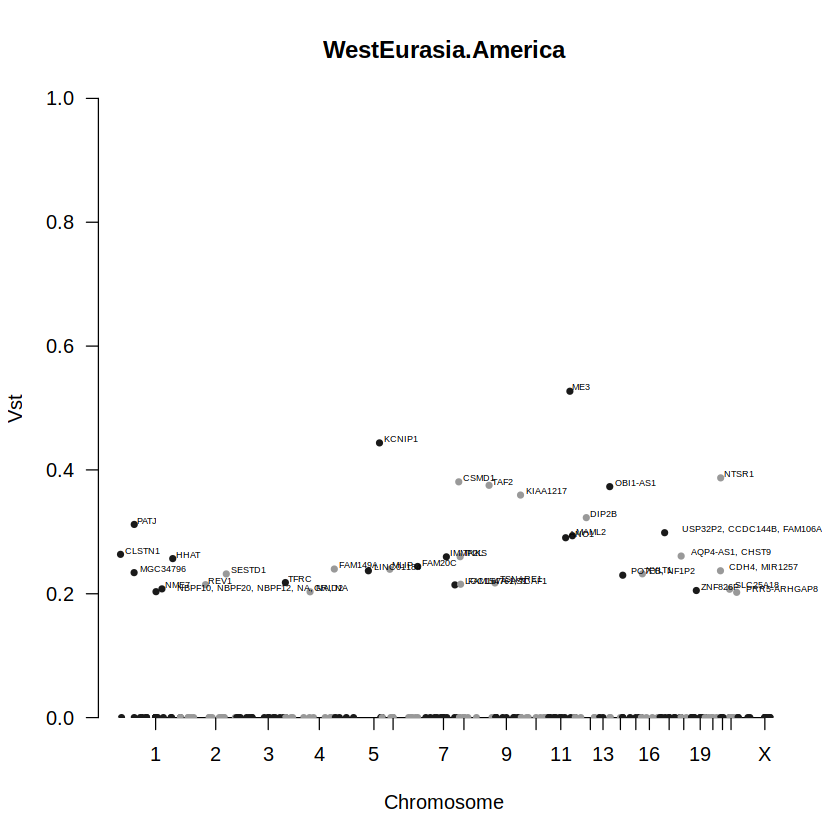

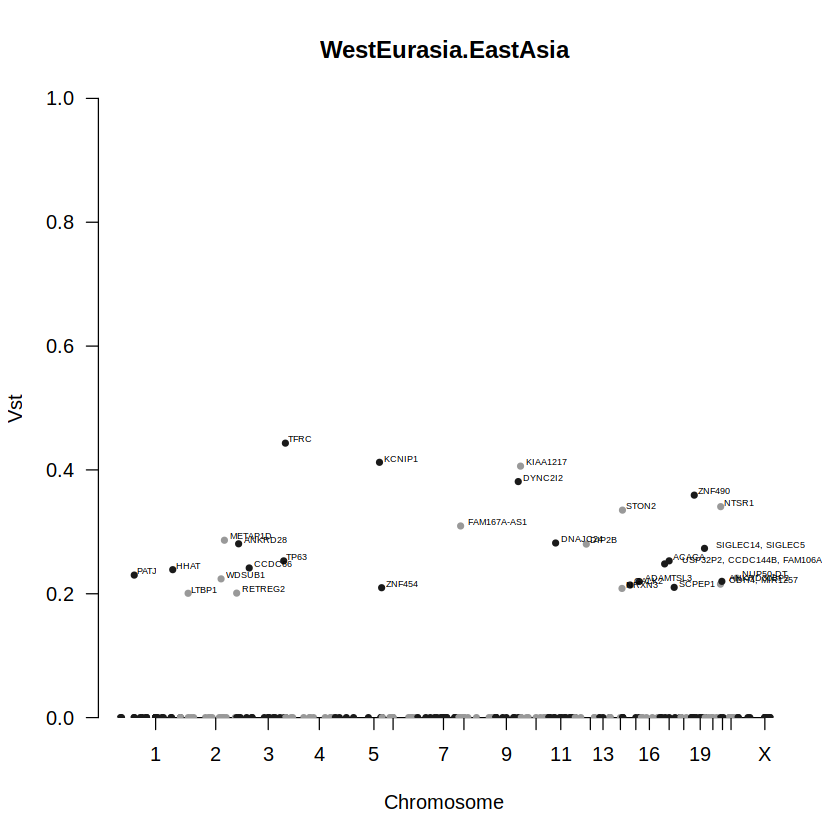

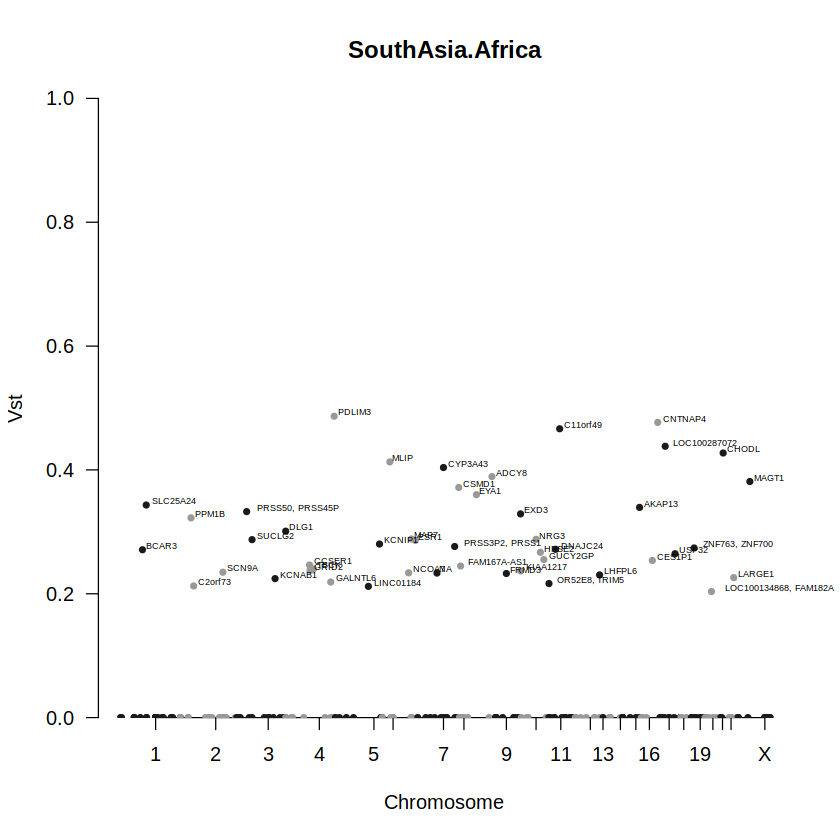

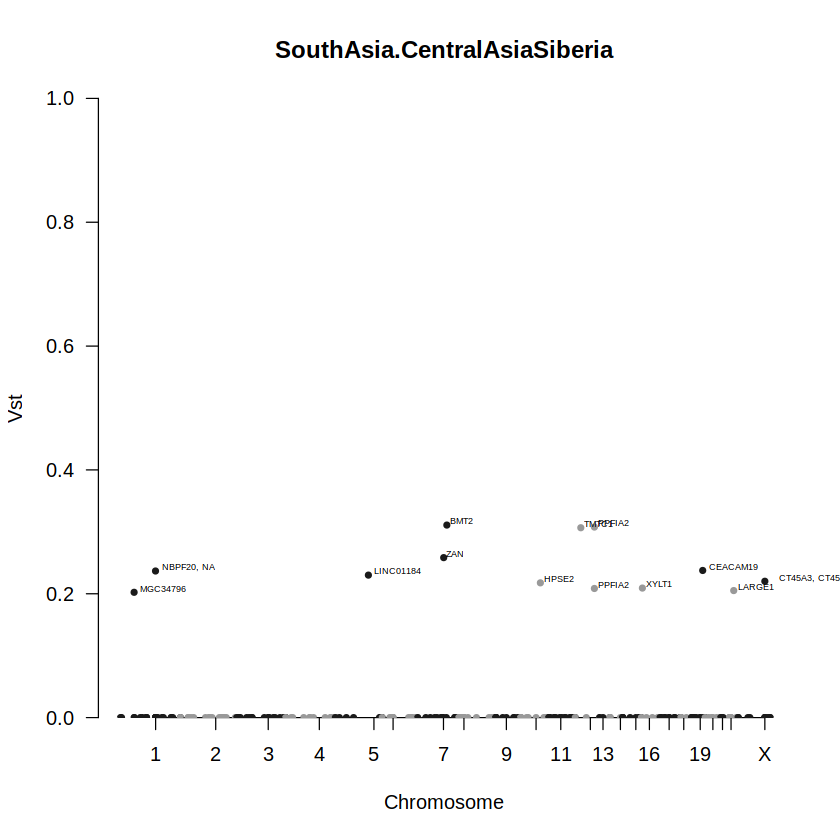

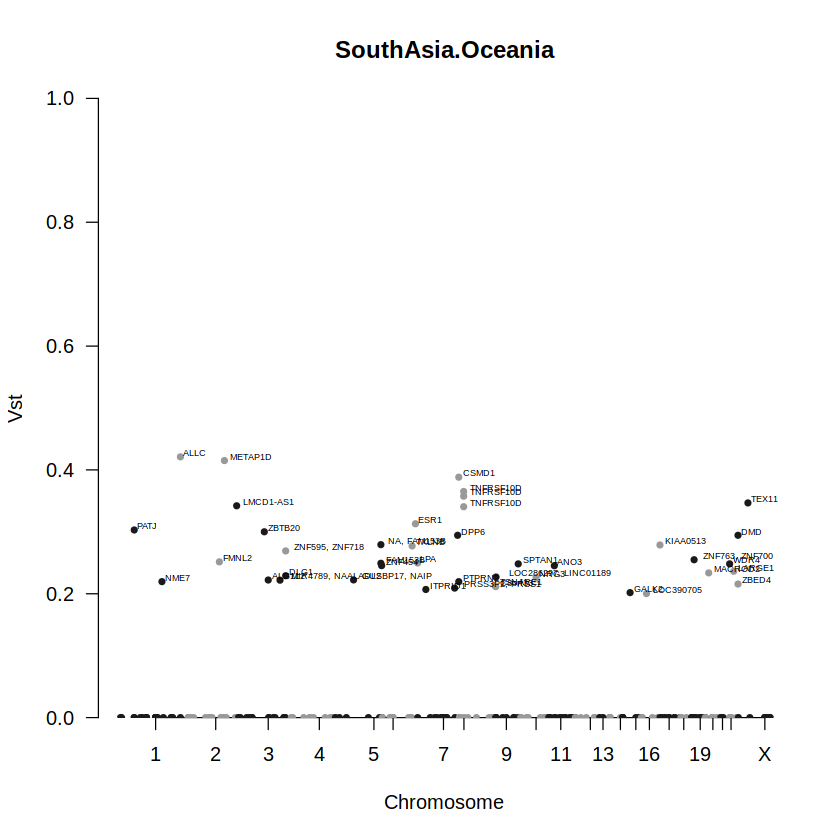

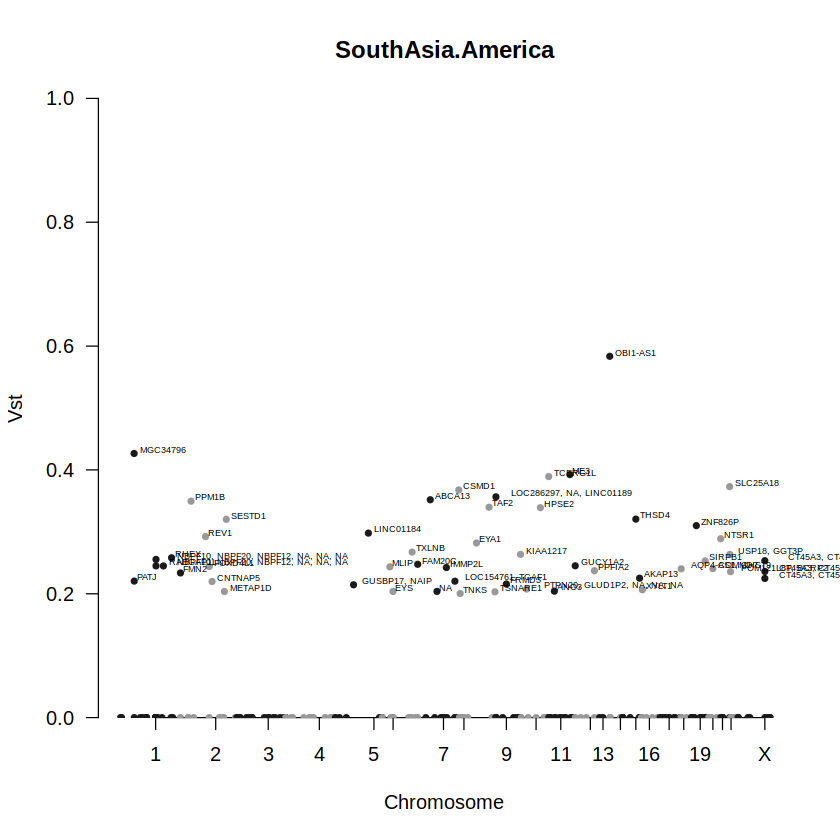

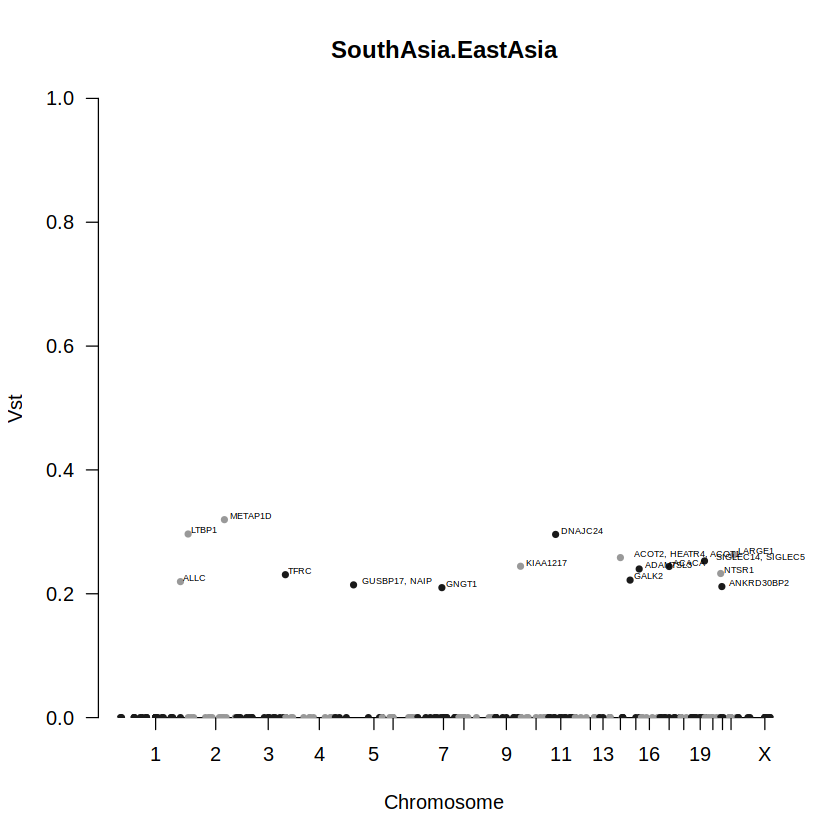

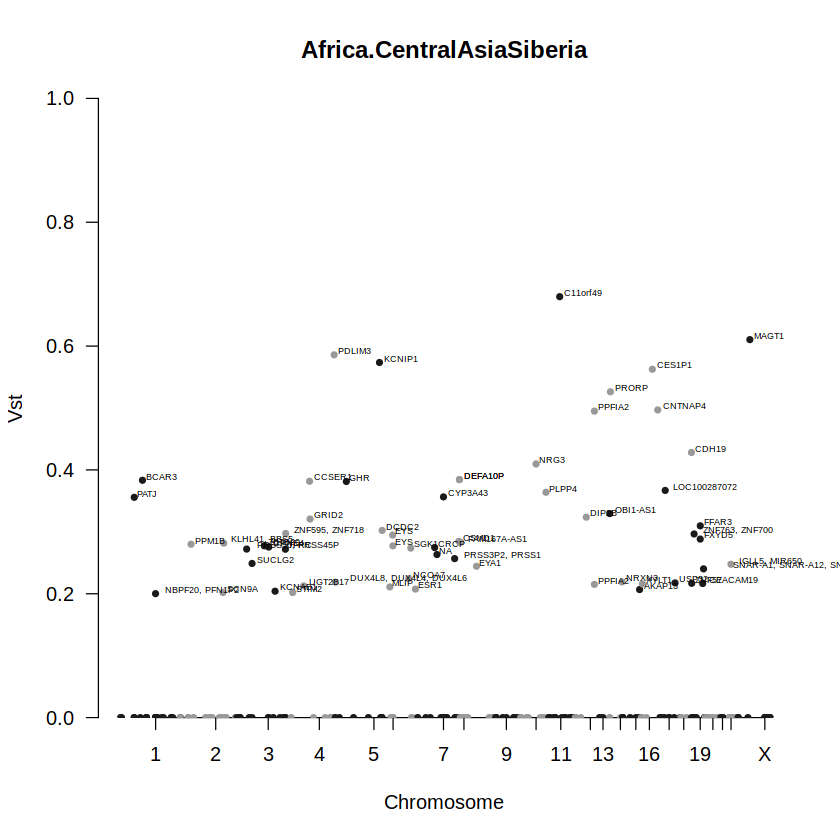

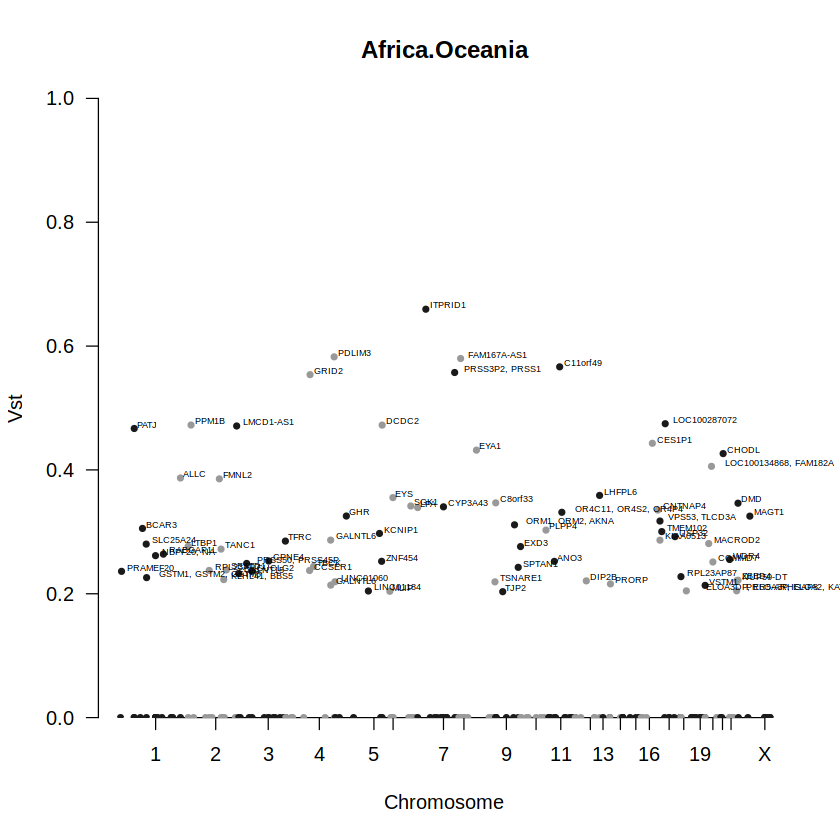

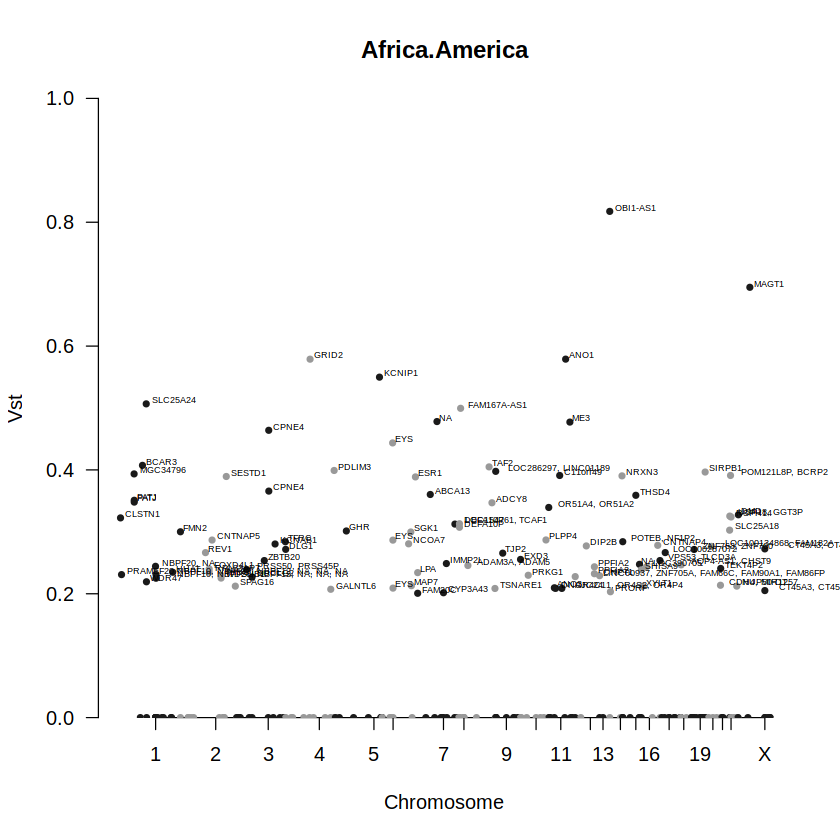

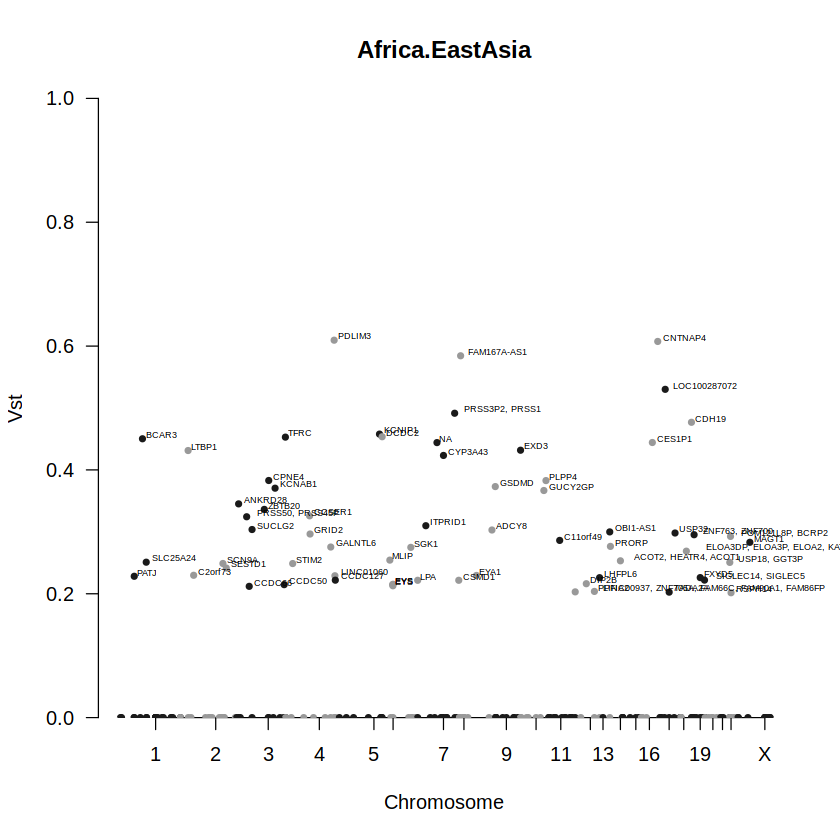

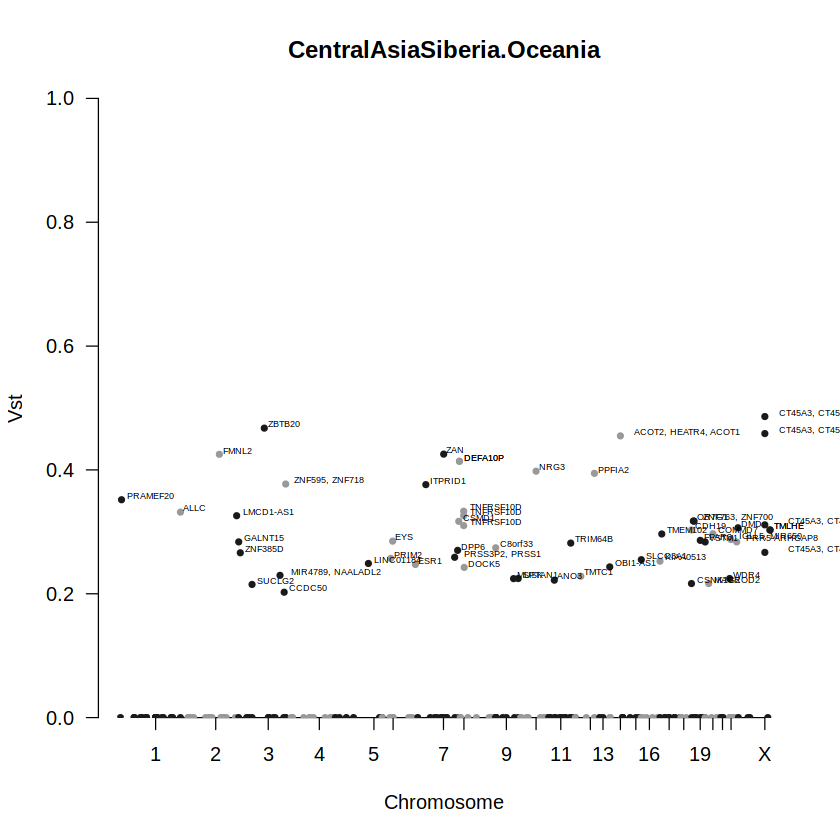

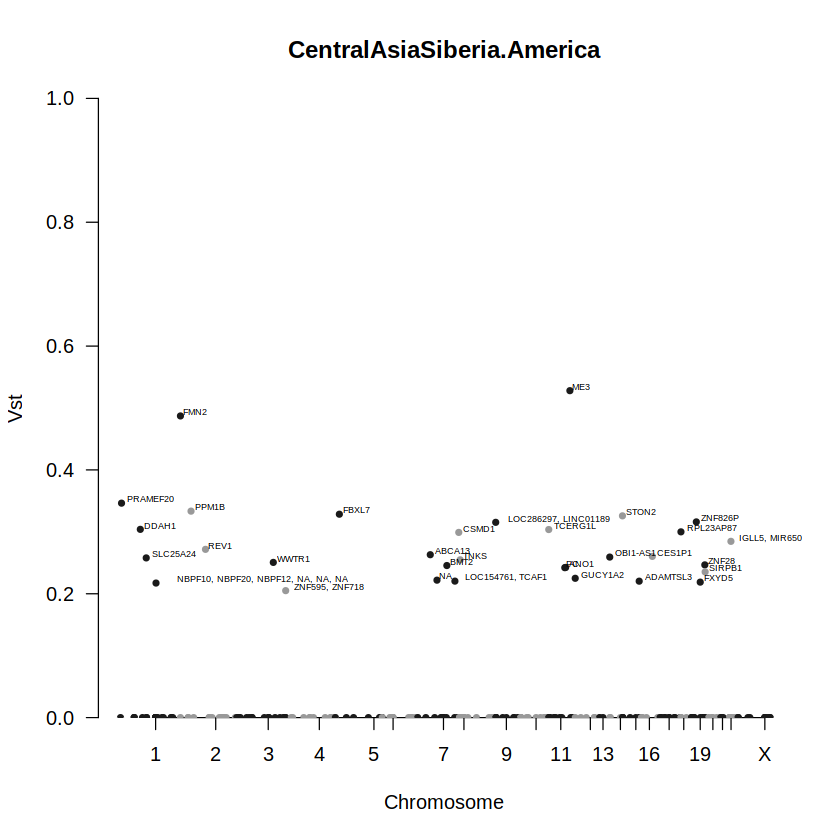

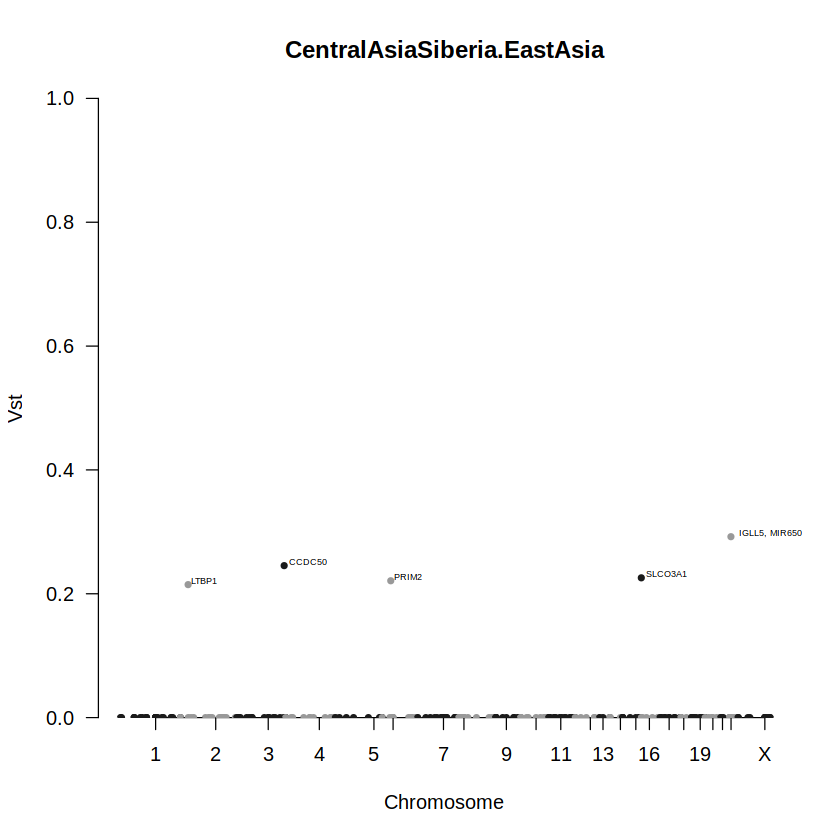

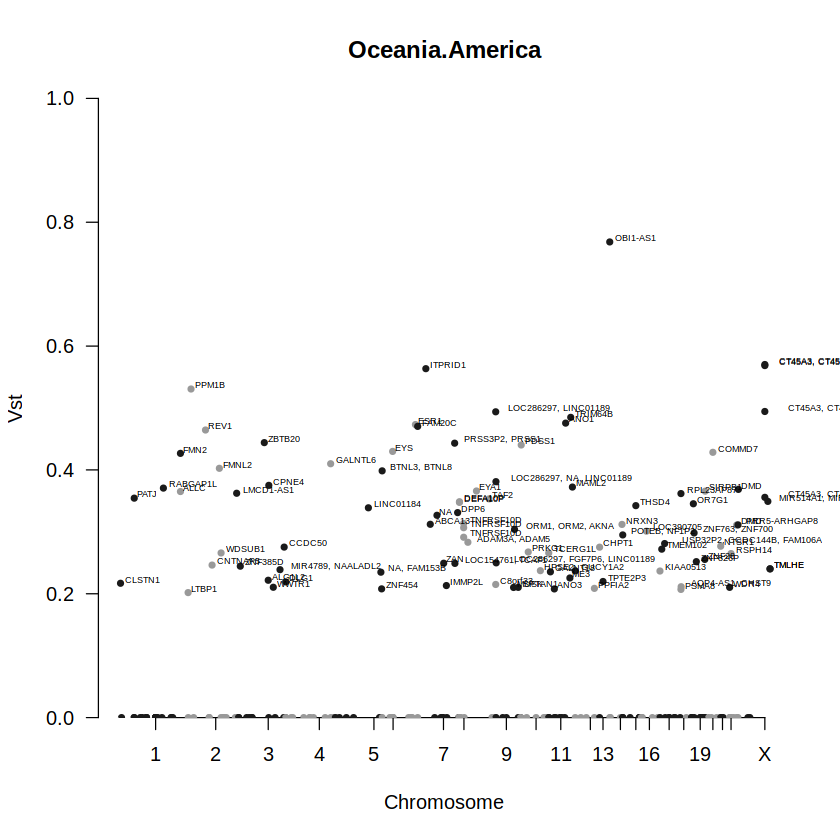

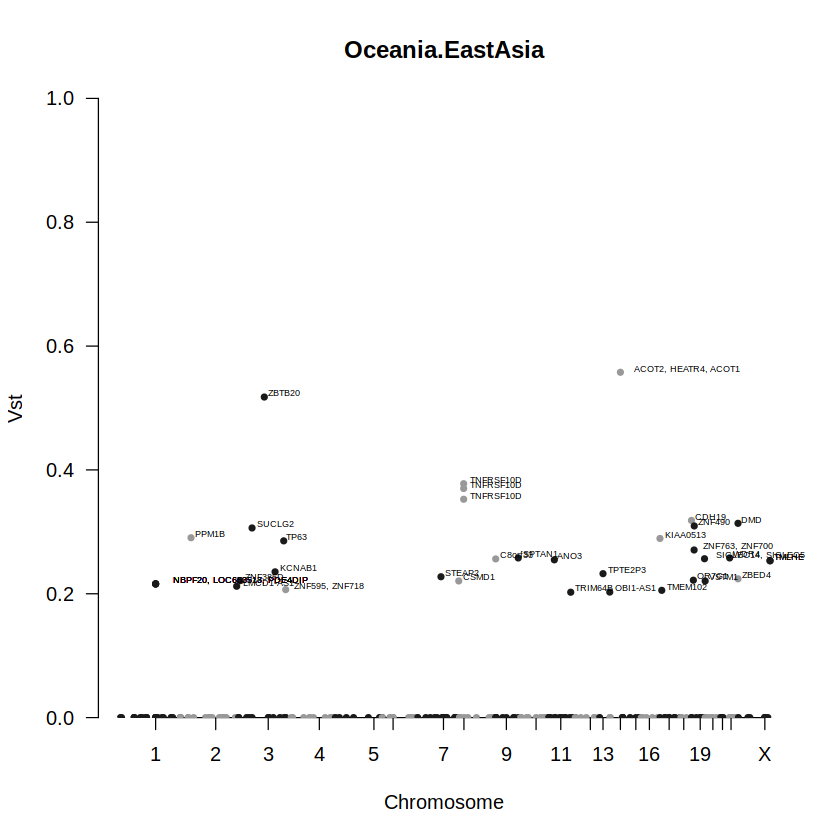

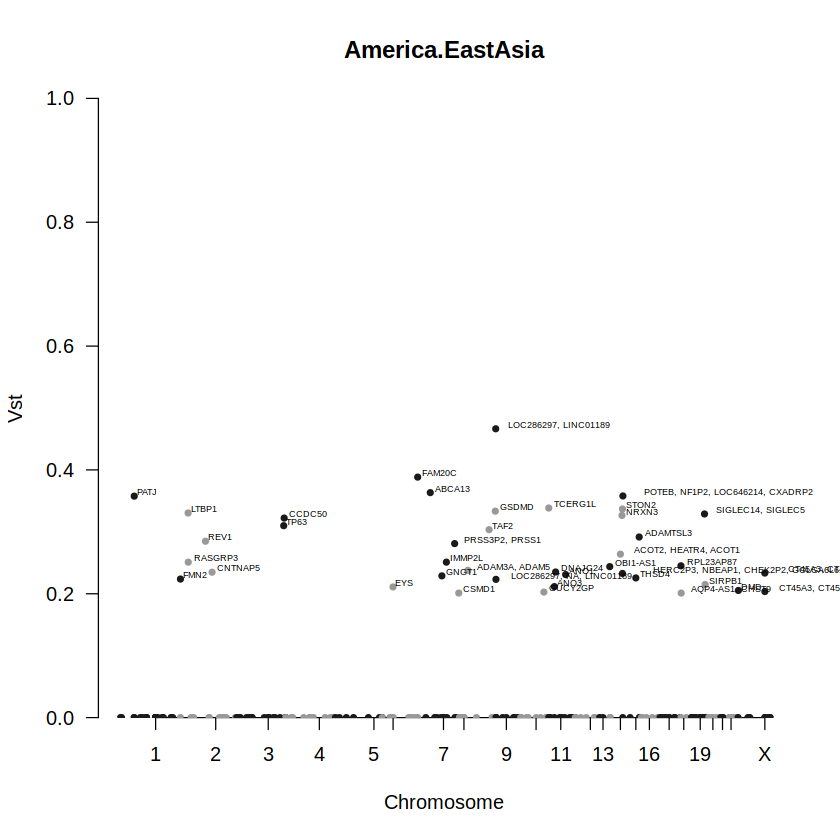

In [19]:
mylist <- list()
for(i in  seq_along(df_merge[,5:ncol(df_merge)])){

  mylist[[i]] <- df_merge[,c(4,1,2,(i+4))]
    names(mylist[[i]])[1] <- 'SNP'
    names(mylist[[i]])[2] <- 'CHR'
    names(mylist[[i]])[3] <- 'BP'
    names(mylist[[i]])[4] <- 'P'
    mylist[[i]][4][is.na(mylist[[i]][4])] <- 0 

  
  manhattan(mylist[[i]], logp = FALSE,  annotatePval= 0.20, annotateTop = FALSE, main=names(df_merge[5:25])[i],  ylab="Vst", chrlabs= c(1:22,"X")) 

}

In [20]:
## SAVING PLOTS 
mylist <- list()
for(i in  seq_along(df_merge[,5:ncol(df_merge)])){

  mylist[[i]] <- df_merge[,c(4,1,2,(i+4))]
    names(mylist[[i]])[1] <- 'SNP'
    names(mylist[[i]])[2] <- 'CHR'
    names(mylist[[i]])[3] <- 'BP'
    names(mylist[[i]])[4] <- 'P'
    mylist[[i]][4][is.na(mylist[[i]][4])] <- 0 

  
  png(file=paste0("manhattan_plots_permutation/",names(df_merge[5:25])[i],".png"))  #+names(df_merge[5:25])[i]+
  manhattan(mylist[[i]], logp = FALSE,  annotatePval= 0.20, annotateTop = FALSE, main=names(df_merge[5:25])[i],  ylab="Vst(passed permutation test)", chrlabs= c(1:22,"X"))
  dev.off() 

}

In [22]:
rnaseq <- read.csv(file='/branchinecta/jbazanwilliamson/rawcounts.csv')

In [7]:
library(limma)
library(Glimma)
library(edgeR)
library(Homo.sapiens)


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA




ERROR: Error in library(Homo.sapiens): there is no package called ‘Homo.sapiens’


<h2> Liftover hg19 to hg38

In [15]:
chain <- import.chain("hg19ToHg38.over.chain")


In [19]:
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
tx_hg18 <- liftOver(tx_hg19, chain)
# ## End(Not run)

Discarding unchained sequences: chr1_gl000191_random, chr1_gl000192_random, chr4_ctg9_hap1, chr4_gl000193_random, chr4_gl000194_random, chr6_apd_hap1, chr6_cox_hap2, chr6_dbb_hap3, chr6_mann_hap4, chr6_mcf_hap5, chr6_qbl_hap6, chr6_ssto_hap7, chr7_gl000195_random, chr9_gl000201_random, chr17_ctg5_hap1, chr17_gl000204_random, chr17_gl000205_random, chr19_gl000209_random, chrUn_gl000211, chrUn_gl000212, chrUn_gl000213, chrUn_gl000214, chrUn_gl000218, chrUn_gl000219, chrUn_gl000220, chrUn_gl000221, chrUn_gl000222, chrUn_gl000223, chrUn_gl000227, chrUn_gl000228, chrUn_gl000229, chrUn_gl000237, chrUn_gl000241, chrUn_gl000243, chrUn_gl000247



In [21]:
tx_hg38 <- liftOver(intervals, chain)

In [22]:
tx_hg38 

GRangesList object of length 570:
[[1]]
GRanges object with 1 range and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]     chr1 8299679-8304121      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

[[2]]
GRanges object with 1 range and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]     chr1 9785378-9803329      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

[[3]]
GRanges object with 3 ranges and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]     chr1 13398836-13400286      *
  [2]     chr1 13400291-13407081      *
  [3]     chr1 13407082-13407203      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

...
<567 more elements>

In [23]:
intervals

GRanges object with 570 ranges and 0 metadata columns:
        seqnames              ranges strand
           <Rle>           <IRanges>  <Rle>
    [1]     chr1     8359739-8364181      *
    [2]     chr1     9845436-9863387      *
    [3]     chr1   13725296-13733660      *
    [4]     chr1   14436060-14439381      *
    [5]     chr1   16148564-16154830      *
    ...      ...                 ...    ...
  [566]     chrX 146037797-146042345      *
  [567]     chrX 146360192-146369374      *
  [568]     chrX 154788811-154840186      *
  [569]     chrX 154789310-154826421      *
  [570]     chrX 154908191-154948137      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths